## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.

## Задание 

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .
2 Оцените ошибку модели из п.1 .
3 Сделайте вывод о том, как изменилась ошибка модели по значениям h.
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [3]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


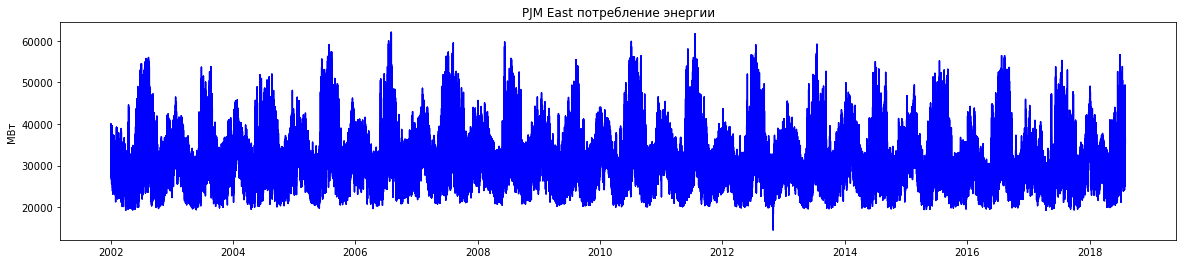

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

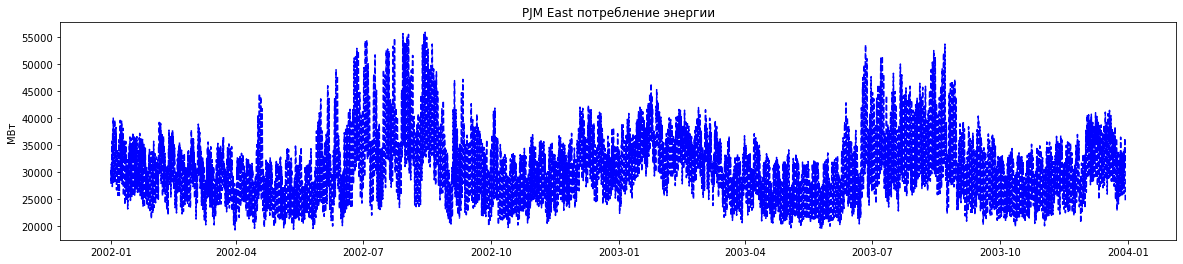

In [5]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
plt.figure(figsize =(20,4))
plt.plot( date_time.index[:24*7*104], date_time.values[:24*7*104], '--b' )

plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Попробуем определить характеристики наших рядов. Посмотрим на ресемплинг (перерасчет рядов в новые временные отрезки,  месячные ).

In [6]:
data_m = data.resample('M').mean()

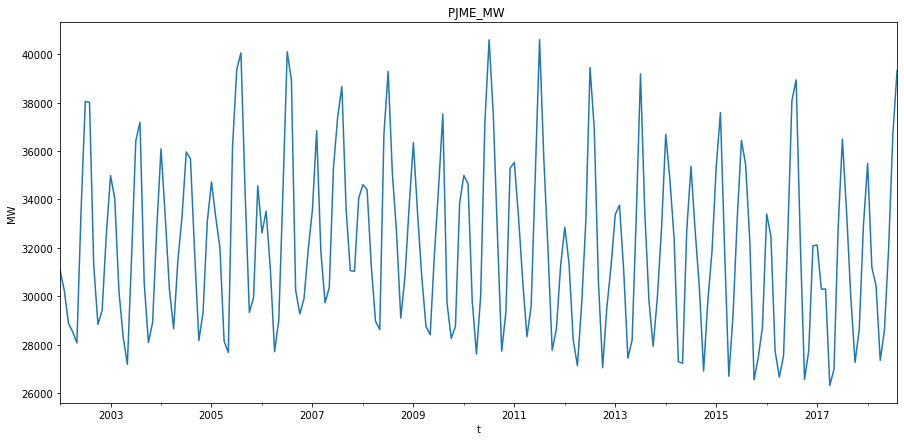

In [7]:
_ = data_m['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

In [8]:
data_y = data.resample('Y').mean()

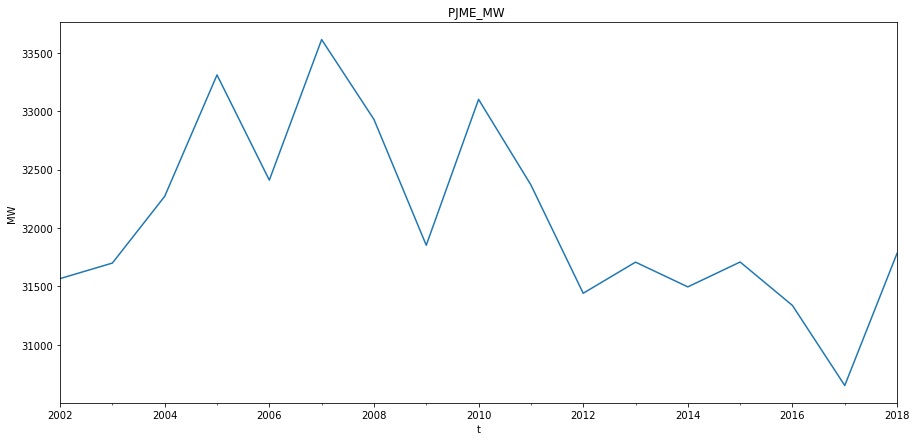

In [9]:
_ = data_y['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

график напоминает случайное явление. Можно проверить как ведут себя первые разности (x(t)-x(t-1)). Если ряд таких разностей стационарен, то можно гарантировать стационарность ряда после удаления основной его части.

In [10]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]

Text(0.5, 1.0, 'Потребление энергии, МВт')

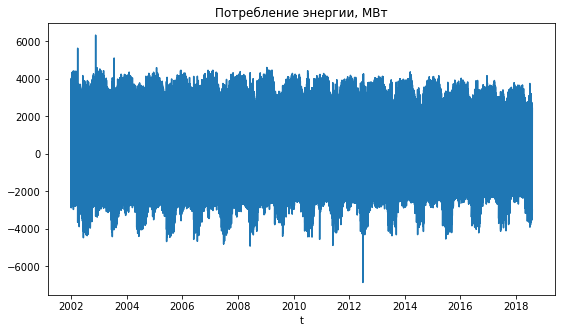

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(data.iloc[:-1].index,d_data)
plt.xlabel('t')
plt.title('Потребление энергии, МВт')

In [12]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Обращаемся к тесту с параметром regression='ctt' - анализировать на постоянные составляющие , линейные и квадратичные тренды. Первый параметр должен содержать одномерный массив или Series

In [13]:
DF_data = sm.tsa.stattools.adfuller(data_m['PJME_MW'].values,regression='ctt')
DF_data

(-2.5774555917292226,
 0.5247860093678968,
 15,
 184,
 {'1%': -4.435220952056536,
  '5%': -3.86487409876613,
  '10%': -3.5733156719443473},
 3230.90609956892)

 месячные средние по потреблению энергию не являются стационарными (у энергии явные сезоны). Проверим первые разности на стационарность.

In [14]:
DF_data_d = sm.tsa.stattools.adfuller(d_data,regression='ctt')

In [15]:
print('коэффициент ADF для 1-й разности потребления энергии: ', DF_data_d[1])

коэффициент ADF для 1-й разности потребления энергии:  0.0


Получили  стационарный ряд, а на основании этого теста наши ряды называют интегрированным рядом,  лаги изменения потребления энергии на месячных.

Это говорит о том, что нужно разделить модели на отдельные составляющие - сезонность у потребления энергии  отделим от стационарных колебаний вокруг этих компонент.


## Анализ результатов теста стационарности по Дики-Фуллеру

Первое значение кортежа ответа содержит показатель статистики теста.
Основное значение теста - второй элемент кортежа ответа: если он равен 0 - ряд стационарен, иначе нет.
Третий параметр - длина временного отрезка (лага), который был использован при исследовании, а следующий за ним число рассмотренных точек ряда. Следующий по тексту ответа словарь содержит критические оценки по МакКинону для 1 % , 5 %, и 10 % вероятности отклонения гипотезы нестационарности ряда (Нулевая гипотеза теста — ряд не стационарен) (https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). 

Из результатов применения ADF следует:
ряд потребление энергии имеет значение DF_data[0] = -2.57  значительно больше критического для 10% (-3.57), а значит с вероятностью большей 10% не стационарен (Нуль-гипотеза отклонена). Он не имеет тренда, но есть сезоны.

## Сглаживание
Будем брать значение в точке с учетом предистории и текущее значение x(i) запишем как усредненную сумму n предшествующих (x(i-n) + x(n-i+1) + ...+ x(i)) * 1/(n + 1). Это пример простой скользящей средней. 

In [16]:
d_data=data.resample('D').mean()

In [17]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

Text(0.5, 1.0, 'PJME_MW')

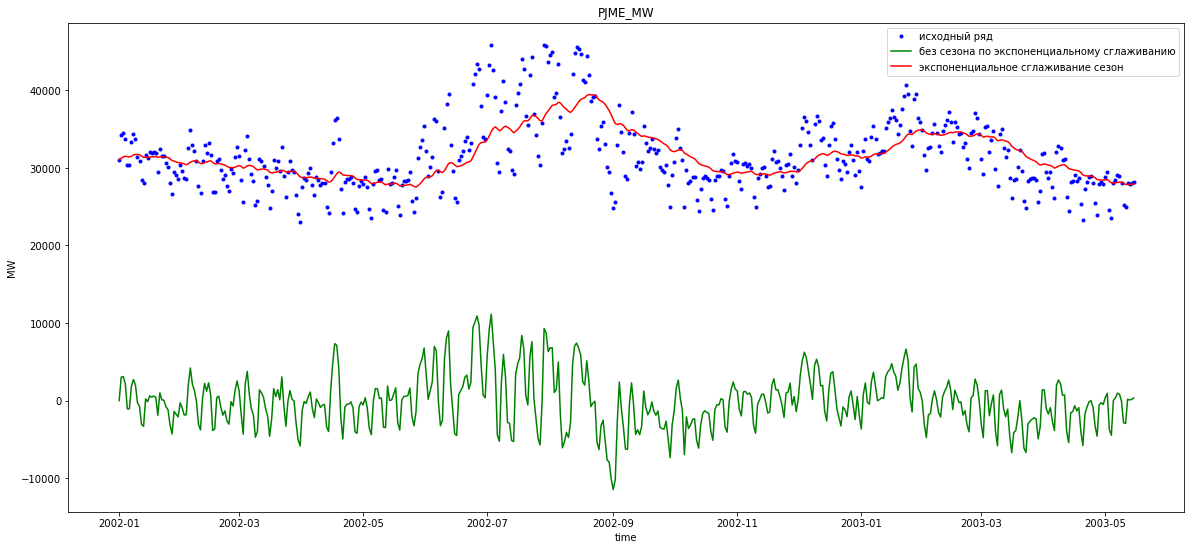

In [18]:

data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [19]:
data_d = data.copy().resample('D').mean()
en_ar = data['PJME_MW'].values
e_s = pd.DataFrame(data = data_d[['PJME_MW']])
data_exp_1 = pd.DataFrame(data = data_exp_1, index = e_s.index)
data_exp_1 

,0
Date,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621
...,...
2018-07-30,35241.910443
2018-07-31,35206.769087
2018-08-01,35407.970216


In [22]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.581319663378352,
 1.2647533241294227e-11,
 33,
 6025,
 {'1%': -4.37305434095676,
  '5%': -3.8333705437821584,
  '10%': -3.5538675485903948},
 107068.01402251713)

Результат удаления явно сезонной составляющей для потребления энергии стационарный ряд.Перейдем к формированю пространства признаков, которое приблизит нас к цели - предсказанию следующего значения ряда.

### Этап Feature Engineering

Добавим истории в наши ряды. Основная информация временного ряда состоит в его предистории. Будем использовать различное число шагов предистории ряда и посмотрим как он будет реагировать на обработку такого представления. Это представление реализовано в Авторегрессионных моделях. В основу авторегрессионных моделей заложено предположение о том, что значение процесса линейно зависит от некоторого количества предыдущих значений того же процесса.

Посмотрим на модели, которые учитывают историю

AR - Авторегрессионная модель, которая является сравнительно простой и оперирует параметром: гдубина регрессии - р. Соберем признаки для такой модели. В качестве признаков будем использовать измерения, которые делали в р предшествующие моменты времени.


In [23]:
df2= pd.DataFrame(data_exp_1)
print(df2.head())
 # добавили историю на глубину 3 измерения от текущего (р=3)
df2['t'] = 0
df2.iloc[1:,1]=df2.iloc[:-1,0].values
df2['t1']=0
df2.iloc[2:,2]=df2.iloc[:-2,0].values
df2['t2']=0
df2.iloc[3:,3]=df2.iloc[:-3,0].values
df2['t7']=0
df2.iloc[7:,4]=df2.iloc[:-7,0].values
df2.fillna(0)

# добавили сглаживание 
df2['exp_0_01'] = exponential_smoothing(df2[0], 0.01)
df2['exp_0_03'] = exponential_smoothing(df2[0], 0.03)
df2['exp_0_08'] = exponential_smoothing(df2[0], 0.08)

# добавим разности - 1-й порядок
df2['diff1'] = 0
df2['diff1'].iloc[1:] = df2.iloc[:-1,0]-df2.iloc[1:,0]
df2.head()



                       0
Date                    
2002-01-01  31080.739130
2002-01-02  31239.779257
2002-01-03  31403.384044
2002-01-04  31518.987759
2002-01-05  31463.294621


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,0,t,t1,t2,t7,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,0.0,31080.739130,31080.739130,31080.739130,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,0.0,31082.329532,31085.510334,31093.462341,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,0.0,31085.540077,31095.046546,31118.256077,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,0.0,31089.874554,31107.764782,31150.314611,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,0.0,31093.608754,31118.430677,31175.353012,0.0


In [ ]:
'''
# adding shift for 3 periods
def shift_add(df, h):
    for i in range(1, h+1):
        df[f't{i}'] = 0
        df.iloc[i:, i] = df.iloc[:-i, 0].values

shift_add(df, 10)'''

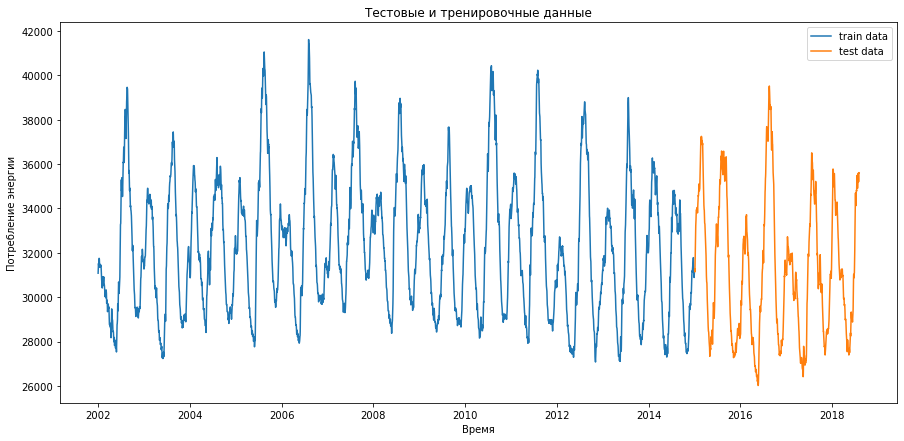

(1310, 9) (1309, 9)


In [52]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
scly = StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train, test = split_data_b(df2, '2015-01-01')

X_train = train.iloc[:-1,:]
y_train = train[df2.columns[0]].values[1:]
X_test = test.iloc[:-1,:]
y_test = test[df2.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train.index.get_level_values('Date'),train[df2.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'),test[df2.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()
print(test_e.shape, X_test_e.shape)

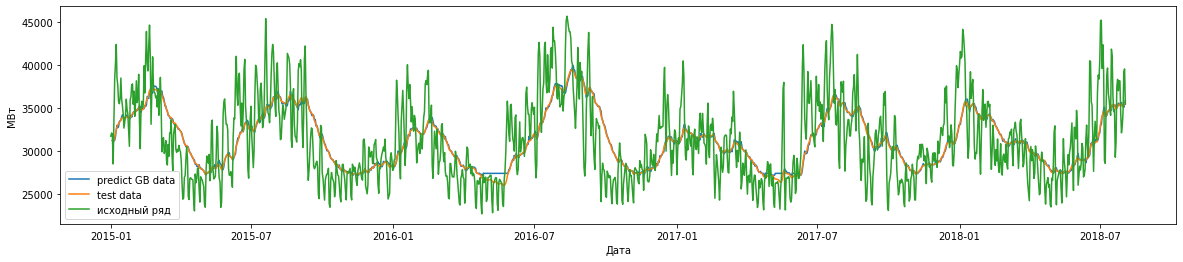

ошибка градиентного бустинга :   0.5620794060282309 %


In [54]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train, y_train ) 
X_test_pred_gb = model_gb.predict(X_test)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Дата')
plt.ylabel('МВт')
plt.plot(test.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test.index[1:],y_test, label='test data')
plt.plot(d_data.loc['2015-01-01':].index, d_data.loc['2015-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

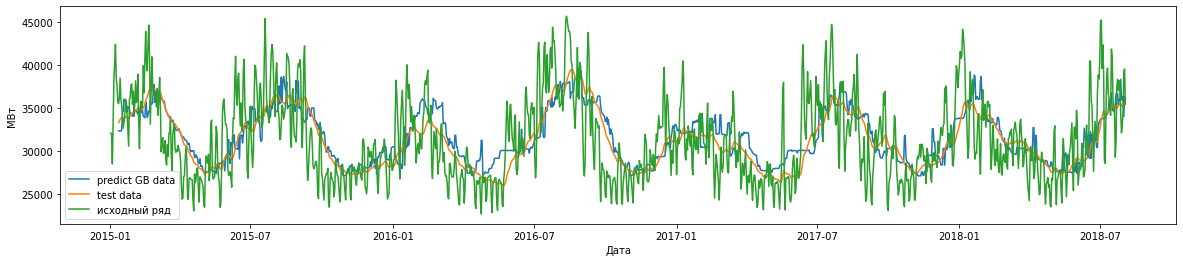

ошибка градиентного бустинга :   3.4443458370763693 %


In [57]:
h=10
X_train = train.iloc[:-h,:]
y_train = train[df2.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df2.columns[0]].values[h:]

model_gb.fit( X_train, y_train) 
X_test_pred_gb = model_gb.predict(X_test)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Дата')
plt.ylabel('МВт')
plt.plot(test.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(d_data.loc['2015-01-02':].index, d_data.loc['2015-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Ошибка  при глубине прогноза h=1 около 0.6 %, что очень хороший результат.

Ошибка  при глубине прогноза h=10 около 3.4 %, тоже очень хороший результат.

При увеличении глубины ошибка модели растет, вероятнее всего чем дальше мы захотим предсказывать, тем больше будет ошибка и с какого-то шага она может расти гораздо быстрее


4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном. 
Ряд с сезоном. Если взять средние значения за год, получится почти стационарный ряд -  с трендом из-за потепления.

б) Количество денег, которые тратят покупатели в интернет магазине.
В опеределенные даты покупают больше. Есть годовой сезон. Если взять ряд средних за год, то у ряда будет тренд, зависящий от роста ВВП, а также просто оттого, что люди привыкают покупать онлайн.

в) Вес растущего котенка.
Пока котенок растет, есть тренд на увеличение, и он не линейный. У дикого кота возможно была бы сезонность.

г) Прирост объема деревьев в лесу от времени. 

В случае дикого леса и рассмотрении по годам это обычно стационарный ряд, сколько отмирает, столько вырастает. Прирост в теплое время года.